# ***CATS VS DOGS IMAGE CLASSIFIER DL PROJECT***

In [ ]:
# Cell 1: Install Required Libraries
!pip install tensorflow keras matplotlib pillow numpy scikit-learn seaborn

In [ ]:
# Cell 2: Import Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
import requests
from PIL import Image
import random

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Cell 3: Download and Setup Dataset
def download_and_extract_dataset():
    """Download cats vs dogs dataset"""
    url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

    # Download dataset
    if not os.path.exists("cats_dogs_dataset.zip"):
        print("Downloading dataset...")
        response = requests.get(url)
        with open("cats_dogs_dataset.zip", "wb") as f:
            f.write(response.content)
        print("Dataset downloaded!")

    # Extract dataset
    if not os.path.exists("PetImages"):
        print("Extracting dataset...")
        with zipfile.ZipFile("cats_dogs_dataset.zip", 'r') as zip_ref:
            zip_ref.extractall()
        print("Dataset extracted!")

    return "PetImages"

# Download dataset
dataset_path = download_and_extract_dataset()

Dataset downloaded!
Extracting dataset...
Dataset extracted!


In [ ]:
# Cell 4: Data Preprocessing and Cleaning
def clean_dataset(dataset_path):
    """Clean corrupted images from dataset"""
    cats_path = os.path.join(dataset_path, "Cat")
    dogs_path = os.path.join(dataset_path, "Dog")

    def remove_corrupted_images(folder_path):
        removed_count = 0
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(file_path)
                img.verify()
            except:
                os.remove(file_path)
                removed_count += 1
        return removed_count

    cats_removed = remove_corrupted_images(cats_path)
    dogs_removed = remove_corrupted_images(dogs_path)

    print(f"Removed {cats_removed} corrupted cat images")
    print(f"Removed {dogs_removed} corrupted dog images")

    cats_count = len(os.listdir(cats_path))
    dogs_count = len(os.listdir(dogs_path))

    print(f"Remaining: {cats_count} cat images, {dogs_count} dog images")

    return cats_count, dogs_count

# Clean dataset
cats_count, dogs_count = clean_dataset(dataset_path)


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removed 2 corrupted cat images
Removed 2 corrupted dog images
Remaining: 12499 cat images, 12499 dog images


In [ ]:
# Cell 5: Create Data Generators with Augmentation
def create_data_generators():
    """Create training and validation data generators"""

    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest',
        validation_split=0.2
    )

    # Validation data generator (no augmentation)
    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )

    validation_generator = validation_datagen.flow_from_directory(
        dataset_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, validation_generator

# Create data generators
train_gen, val_gen = create_data_generators()

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


Sample images from the dataset:


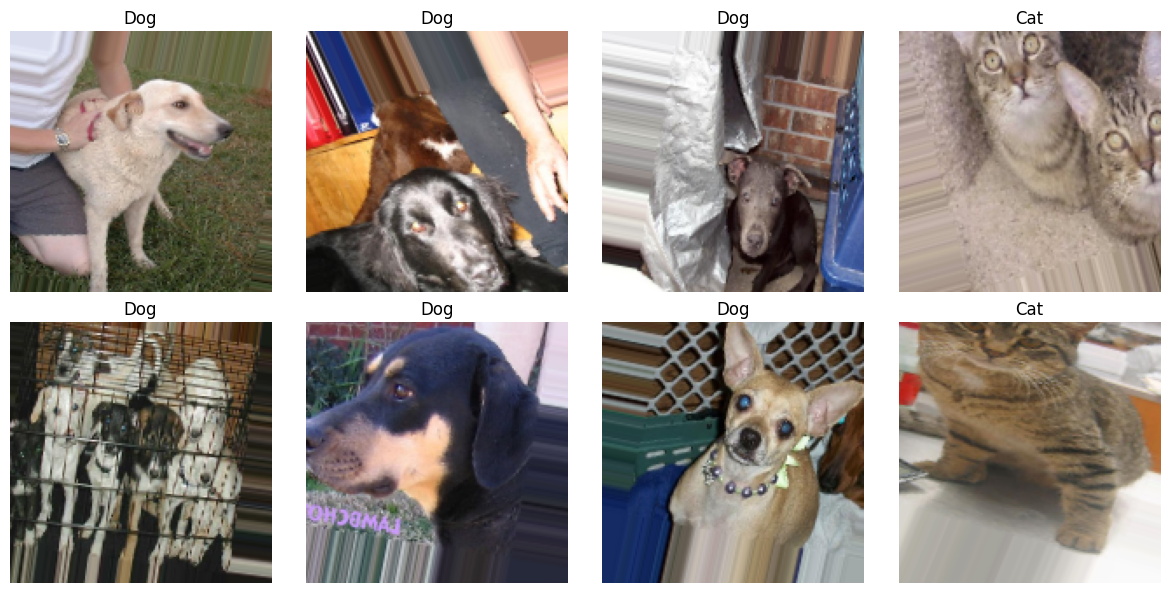

In [ ]:
# Cell 6: Visualize Sample Images
def visualize_samples(generator, num_samples=8):
    """Visualize sample images from the dataset"""

    # Get a batch of images
    images, labels = next(generator)

    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    class_names = ['Cat', 'Dog']

    for i in range(num_samples):
        axes[i].imshow(images[i])
        axes[i].set_title(f'{class_names[int(labels[i])]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples
print("Sample images from the dataset:")
visualize_samples(train_gen)

In [ ]:
# Cell 7: Build Enhanced CNN Model
def build_enhanced_model():
    """Build an enhanced CNN model with dropout and batch normalization"""

    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Build model
model = build_enhanced_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Cell 8: Compile Model with Advanced Optimizer
def compile_model(model):
    """Compile model with advanced optimizer and metrics"""

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Compile model
model = compile_model(model)

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,947,009 (26.50 MB)

 Trainable params: 6,945,025 (26.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# Cell 9: Setup Callbacks for Training
def setup_callbacks():
    """Setup callbacks for better training"""

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=0.00001
        ),
        keras.callbacks.ModelCheckpoint(
            filepath='best_model.h5',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]

    return callbacks

# Setup callbacks
callbacks = setup_callbacks()


In [ ]:
# Cell 10: Train the Model
def train_model(model, train_gen, val_gen, callbacks, epochs=30):
    """Train the model with callbacks"""

    print("Starting training...")

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Train model
history = train_model(model, train_gen, val_gen, callbacks)

Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
218/625 ━━━━━━━━━━━━━━━━━━━━ 1:29 221ms/step - accuracy: 0.5467 - loss: 1.0723 - precision: 0.5478 - recall: 0.6145

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5626 - loss: 0.9435 - precision: 0.5613 - recall: 0.5921

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 169s 246ms/step - accuracy: 0.5627 - loss: 0.9432 - precision: 0.5613 - recall: 0.5921 - val_accuracy: 0.6449 - val_loss: 0.6121 - val_precision: 0.7119 - val_recall: 0.4866 - learning_rate: 0.0010
Epoch 2/30
194/625 ━━━━━━━━━━━━━━━━━━━━ 1:33 217ms/step - accuracy: 0.6453 - loss: 0.6320 - precision: 0.6396 - recall: 0.6430

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6524 - loss: 0.6233 - precision: 0.6557 - recall: 0.6359

625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.6524 - loss: 0.6233 - precision: 0.6557 - recall: 0.6359 - val_accuracy: 0.6601 - val_loss: 0.6238 - val_precision: 0.7941 - val_recall: 0.4322 - learning_rate: 0.0010
Epoch 3/30
144/625 ━━━━━━━━━━━━━━━━━━━━ 1:45 219ms/step - accuracy: 0.7042 - loss: 0.5671 - precision: 0.7084 - recall: 0.6841

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7019 - loss: 0.5682 - precision: 0.7069 - recall: 0.6801

625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.7019 - loss: 0.5682 - precision: 0.7070 - recall: 0.6801 - val_accuracy: 0.6867 - val_loss: 0.5664 - val_precision: 0.6263 - val_recall: 0.9256 - learning_rate: 0.0010
Epoch 4/30
234/625 ━━━━━━━━━━━━━━━━━━━━ 1:25 217ms/step - accuracy: 0.7415 - loss: 0.5213 - precision: 0.7490 - recall: 0.7305

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7481 - loss: 0.5169 - precision: 0.7554 - recall: 0.7360

625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.7481 - loss: 0.5168 - precision: 0.7554 - recall: 0.7360 - val_accuracy: 0.8017 - val_loss: 0.4311 - val_precision: 0.7566 - val_recall: 0.8896 - learning_rate: 0.0010
Epoch 5/30
441/625 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.7826 - loss: 0.4610 - precision: 0.7878 - recall: 0.7764

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 239ms/step - accuracy: 0.7828 - loss: 0.4604 - precision: 0.7877 - recall: 0.7768 - val_accuracy: 0.7513 - val_loss: 0.5170 - val_precision: 0.8380 - val_recall: 0.6230 - learning_rate: 0.0010
Epoch 6/30
354/625 ━━━━━━━━━━━━━━━━━━━━ 1:00 223ms/step - accuracy: 0.8059 - loss: 0.4297 - precision: 0.8187 - recall: 0.7856

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8064 - loss: 0.4266 - precision: 0.8166 - recall: 0.7901

625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 237ms/step - accuracy: 0.8064 - loss: 0.4266 - precision: 0.8166 - recall: 0.7901 - val_accuracy: 0.8219 - val_loss: 0.3785 - val_precision: 0.9433 - val_recall: 0.6851 - learning_rate: 0.0010
Epoch 7/30
136/625 ━━━━━━━━━━━━━━━━━━━━ 1:46 218ms/step - accuracy: 0.8166 - loss: 0.3949 - precision: 0.8351 - recall: 0.8044

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8253 - loss: 0.3890 - precision: 0.8307 - recall: 0.8224

625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 238ms/step - accuracy: 0.8253 - loss: 0.3889 - precision: 0.8307 - recall: 0.8224 - val_accuracy: 0.8517 - val_loss: 0.3351 - val_precision: 0.9351 - val_recall: 0.7559 - learning_rate: 0.0010
Epoch 8/30
256/625 ━━━━━━━━━━━━━━━━━━━━ 1:22 224ms/step - accuracy: 0.8267 - loss: 0.3808 - precision: 0.8290 - recall: 0.8220

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8296 - loss: 0.3770 - precision: 0.8318 - recall: 0.8250

625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 236ms/step - accuracy: 0.8296 - loss: 0.3770 - precision: 0.8318 - recall: 0.8250 - val_accuracy: 0.8687 - val_loss: 0.2989 - val_precision: 0.9332 - val_recall: 0.7943 - learning_rate: 0.0010
Epoch 9/30
233/625 ━━━━━━━━━━━━━━━━━━━━ 1:27 224ms/step - accuracy: 0.8439 - loss: 0.3474 - precision: 0.8465 - recall: 0.8439

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 205s 240ms/step - accuracy: 0.8464 - loss: 0.3474 - precision: 0.8476 - recall: 0.8463 - val_accuracy: 0.8145 - val_loss: 0.4026 - val_precision: 0.9323 - val_recall: 0.6783 - learning_rate: 0.0010
Epoch 10/30
613/625 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.8538 - loss: 0.3325 - precision: 0.8555 - recall: 0.8565

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 235ms/step - accuracy: 0.8539 - loss: 0.3324 - precision: 0.8555 - recall: 0.8565 - val_accuracy: 0.8219 - val_loss: 0.3736 - val_precision: 0.9487 - val_recall: 0.6807 - learning_rate: 0.0010
Epoch 11/30
561/625 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.8620 - loss: 0.3192 - precision: 0.8630 - recall: 0.8612

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8621 - loss: 0.3187 - precision: 0.8631 - recall: 0.8613

625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.8621 - loss: 0.3187 - precision: 0.8631 - recall: 0.8613 - val_accuracy: 0.8800 - val_loss: 0.2675 - val_precision: 0.9498 - val_recall: 0.8023 - learning_rate: 0.0010
Epoch 12/30
242/625 ━━━━━━━━━━━━━━━━━━━━ 1:25 224ms/step - accuracy: 0.8756 - loss: 0.2947 - precision: 0.8733 - recall: 0.8699

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.8712 - loss: 0.3013 - precision: 0.8721 - recall: 0.8654 - val_accuracy: 0.8627 - val_loss: 0.3120 - val_precision: 0.9311 - val_recall: 0.7835 - learning_rate: 0.0010
Epoch 13/30
185/625 ━━━━━━━━━━━━━━━━━━━━ 1:38 224ms/step - accuracy: 0.8713 - loss: 0.3002 - precision: 0.8728 - recall: 0.8746

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8720 - loss: 0.2986 - precision: 0.8729 - recall: 0.8730

625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.8720 - loss: 0.2986 - precision: 0.8729 - recall: 0.8730 - val_accuracy: 0.8966 - val_loss: 0.2410 - val_precision: 0.9588 - val_recall: 0.8287 - learning_rate: 0.0010
Epoch 14/30
327/625 ━━━━━━━━━━━━━━━━━━━━ 1:05 219ms/step - accuracy: 0.8722 - loss: 0.2947 - precision: 0.8712 - recall: 0.8703

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8745 - loss: 0.2924 - precision: 0.8732 - recall: 0.8738

625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 231ms/step - accuracy: 0.8745 - loss: 0.2924 - precision: 0.8732 - recall: 0.8738 - val_accuracy: 0.9160 - val_loss: 0.2120 - val_precision: 0.8880 - val_recall: 0.9520 - learning_rate: 0.0010
Epoch 15/30
115/625 ━━━━━━━━━━━━━━━━━━━━ 1:50 216ms/step - accuracy: 0.8776 - loss: 0.2779 - precision: 0.8782 - recall: 0.8810

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 232ms/step - accuracy: 0.8781 - loss: 0.2796 - precision: 0.8793 - recall: 0.8799 - val_accuracy: 0.8948 - val_loss: 0.2764 - val_precision: 0.9669 - val_recall: 0.8175 - learning_rate: 0.0010
Epoch 16/30
335/625 ━━━━━━━━━━━━━━━━━━━━ 1:02 217ms/step - accuracy: 0.8745 - loss: 0.2859 - precision: 0.8682 - recall: 0.8833

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 231ms/step - accuracy: 0.8757 - loss: 0.2835 - precision: 0.8716 - recall: 0.8820 - val_accuracy: 0.8950 - val_loss: 0.2577 - val_precision: 0.8429 - val_recall: 0.9708 - learning_rate: 0.0010
Epoch 17/30
347/625 ━━━━━━━━━━━━━━━━━━━━ 1:01 221ms/step - accuracy: 0.8836 - loss: 0.2693 - precision: 0.8796 - recall: 0.8879

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.8839 - loss: 0.2707 - precision: 0.8797 - recall: 0.8890 - val_accuracy: 0.8896 - val_loss: 0.2662 - val_precision: 0.9028 - val_recall: 0.8731 - learning_rate: 0.0010
Epoch 18/30
118/625 ━━━━━━━━━━━━━━━━━━━━ 1:51 220ms/step - accuracy: 0.8864 - loss: 0.2506 - precision: 0.8803 - recall: 0.8925

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8940 - loss: 0.2444 - precision: 0.8915 - recall: 0.8972

625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.8940 - loss: 0.2444 - precision: 0.8915 - recall: 0.8972 - val_accuracy: 0.9336 - val_loss: 0.1664 - val_precision: 0.9298 - val_recall: 0.9380 - learning_rate: 5.0000e-04
Epoch 19/30
525/625 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - accuracy: 0.9048 - loss: 0.2325 - precision: 0.8995 - recall: 0.9107

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 231ms/step - accuracy: 0.9043 - loss: 0.2332 - precision: 0.8998 - recall: 0.9093 - val_accuracy: 0.9110 - val_loss: 0.2184 - val_precision: 0.9750 - val_recall: 0.8435 - learning_rate: 5.0000e-04
Epoch 20/30
151/625 ━━━━━━━━━━━━━━━━━━━━ 1:41 215ms/step - accuracy: 0.9030 - loss: 0.2346 - precision: 0.8945 - recall: 0.9073

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9061 - loss: 0.2274 - precision: 0.9029 - recall: 0.9076

625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.9061 - loss: 0.2274 - precision: 0.9029 - recall: 0.9076 - val_accuracy: 0.9452 - val_loss: 0.1432 - val_precision: 0.9423 - val_recall: 0.9484 - learning_rate: 5.0000e-04
Epoch 21/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9053 - loss: 0.2237 - precision: 0.8994 - recall: 0.9131

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.9053 - loss: 0.2237 - precision: 0.8995 - recall: 0.9131 - val_accuracy: 0.9296 - val_loss: 0.1679 - val_precision: 0.9617 - val_recall: 0.8948 - learning_rate: 5.0000e-04
Epoch 22/30
194/625 ━━━━━━━━━━━━━━━━━━━━ 1:37 225ms/step - accuracy: 0.9098 - loss: 0.2207 - precision: 0.9074 - recall: 0.9095

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 234ms/step - accuracy: 0.9092 - loss: 0.2195 - precision: 0.9076 - recall: 0.9102 - val_accuracy: 0.9332 - val_loss: 0.1617 - val_precision: 0.9601 - val_recall: 0.9040 - learning_rate: 5.0000e-04
Epoch 23/30
354/625 ━━━━━━━━━━━━━━━━━━━━ 58s 217ms/step - accuracy: 0.9142 - loss: 0.2173 - precision: 0.9107 - recall: 0.9118

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 231ms/step - accuracy: 0.9119 - loss: 0.2209 - precision: 0.9098 - recall: 0.9104 - val_accuracy: 0.9386 - val_loss: 0.1551 - val_precision: 0.9518 - val_recall: 0.9240 - learning_rate: 5.0000e-04
Epoch 24/30
 52/625 ━━━━━━━━━━━━━━━━━━━━ 2:02 214ms/step - accuracy: 0.9081 - loss: 0.2175 - precision: 0.9049 - recall: 0.9142

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 229ms/step - accuracy: 0.9100 - loss: 0.2132 - precision: 0.9052 - recall: 0.9160 - val_accuracy: 0.9436 - val_loss: 0.1443 - val_precision: 0.9567 - val_recall: 0.9292 - learning_rate: 2.5000e-04
Epoch 25/30
485/625 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.9175 - loss: 0.1986 - precision: 0.9142 - recall: 0.9226

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9180 - loss: 0.1982 - precision: 0.9148 - recall: 0.9226

625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.9180 - loss: 0.1982 - precision: 0.9148 - recall: 0.9226 - val_accuracy: 0.9474 - val_loss: 0.1336 - val_precision: 0.9519 - val_recall: 0.9424 - learning_rate: 2.5000e-04
Epoch 26/30
118/625 ━━━━━━━━━━━━━━━━━━━━ 1:49 216ms/step - accuracy: 0.9238 - loss: 0.1965 - precision: 0.9167 - recall: 0.9314

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9203 - loss: 0.1938 - precision: 0.9171 - recall: 0.9244

625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 231ms/step - accuracy: 0.9203 - loss: 0.1938 - precision: 0.9171 - recall: 0.9244 - val_accuracy: 0.9478 - val_loss: 0.1358 - val_precision: 0.9465 - val_recall: 0.9492 - learning_rate: 2.5000e-04
Epoch 27/30
160/625 ━━━━━━━━━━━━━━━━━━━━ 1:42 221ms/step - accuracy: 0.9286 - loss: 0.1795 - precision: 0.9156 - recall: 0.9415

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 236ms/step - accuracy: 0.9205 - loss: 0.1900 - precision: 0.9138 - recall: 0.9272 - val_accuracy: 0.9466 - val_loss: 0.1309 - val_precision: 0.9551 - val_recall: 0.9372 - learning_rate: 2.5000e-04
Epoch 28/30
266/625 ━━━━━━━━━━━━━━━━━━━━ 1:17 216ms/step - accuracy: 0.9186 - loss: 0.1869 - precision: 0.9133 - recall: 0.9238

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 229ms/step - accuracy: 0.9205 - loss: 0.1882 - precision: 0.9172 - recall: 0.9237 - val_accuracy: 0.9468 - val_loss: 0.1343 - val_precision: 0.9548 - val_recall: 0.9380 - learning_rate: 2.5000e-04
Epoch 29/30
172/625 ━━━━━━━━━━━━━━━━━━━━ 1:36 214ms/step - accuracy: 0.9192 - loss: 0.1874 - precision: 0.9242 - recall: 0.9178

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.9196 - loss: 0.1889 - precision: 0.9196 - recall: 0.9210 - val_accuracy: 0.9470 - val_loss: 0.1328 - val_precision: 0.9544 - val_recall: 0.9388 - learning_rate: 2.5000e-04
Epoch 30/30
286/625 ━━━━━━━━━━━━━━━━━━━━ 1:12 215ms/step - accuracy: 0.9252 - loss: 0.1826 - precision: 0.9276 - recall: 0.9260

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9240 - loss: 0.1858 - precision: 0.9244 - recall: 0.9257

625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 229ms/step - accuracy: 0.9240 - loss: 0.1858 - precision: 0.9244 - recall: 0.9257 - val_accuracy: 0.9496 - val_loss: 0.1288 - val_precision: 0.9558 - val_recall: 0.9428 - learning_rate: 2.5000e-04


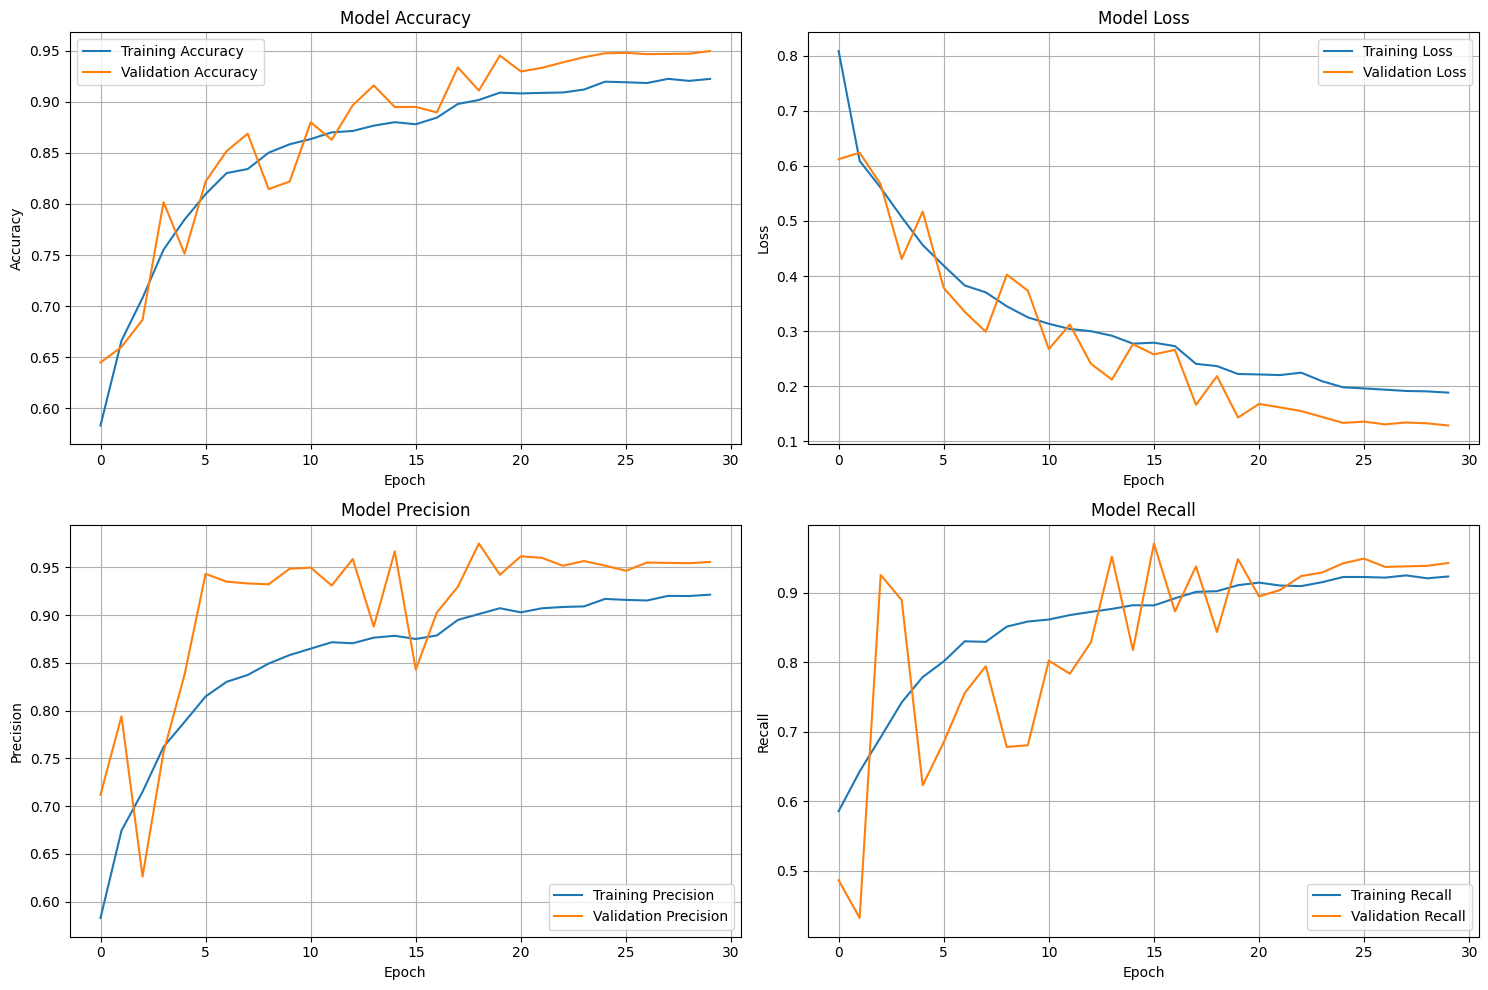

In [ ]:
# Cell 11: Visualize Training History
def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
# Cell 12: Evaluate Model Performance
def evaluate_model(model, val_gen):
    """Evaluate model performance with detailed metrics"""

    # Get predictions
    val_gen.reset()
    predictions = model.predict(val_gen)
    predicted_classes = (predictions > 0.5).astype(int)

    # Get true labels
    true_classes = val_gen.classes
    class_names = ['Cat', 'Dog']

    # Print classification report
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Calculate additional metrics
    accuracy = np.trace(cm) / np.sum(cm)
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f"\nDetailed Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

    return accuracy, precision, recall, f1_score

# Evaluate model
metrics = evaluate_model(model, val_gen)

In [ ]:
# Cell 13: Prediction Function with Visualization
def predict_and_visualize(model, image_path=None, num_predictions=6):
    """Make predictions on new images and visualize results"""

    if image_path is None:
        # Use random images from validation set
        val_gen.reset()
        images, labels = next(val_gen)

        # Select random images
        indices = random.sample(range(len(images)), num_predictions)
        selected_images = [images[i] for i in indices]
        true_labels = [labels[i] for i in indices]
    else:
        # Load and preprocess single image
        img = Image.open(image_path)
        img = img.resize((150, 150))
        img_array = np.array(img) / 255.0
        selected_images = [img_array]
        true_labels = [None]

    # Make predictions
    predictions = []
    for img in selected_images:
        img_batch = np.expand_dims(img, axis=0)
        pred = model.predict(img_batch)[0][0]
        predictions.append(pred)

    # Visualize results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    class_names = ['Cat', 'Dog']

    for i, (img, pred) in enumerate(zip(selected_images, predictions)):
        predicted_class = 'Dog' if pred > 0.5 else 'Cat'
        confidence = pred if pred > 0.5 else 1 - pred

        axes[i].imshow(img)

        if true_labels[i] is not None:
            true_class = class_names[int(true_labels[i])]
            color = 'green' if predicted_class == true_class else 'red'
            axes[i].set_title(f'True: {true_class}\nPred: {predicted_class} ({confidence:.2f})', color=color)
        else:
            axes[i].set_title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}')

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Make predictions and visualize
print("Sample predictions:")
predict_and_visualize(model)

In [ ]:
# Cell 14: Save Model and Create Deployment Function
def save_model_and_create_deployment():
    """Save the trained model and create deployment function"""

    # Save model
    model.save('cats_dogs_classifier.h5')
    print("Model saved as 'cats_dogs_classifier.h5'")

    # Create deployment function
    def deploy_model(image_path):
        """Deploy model for single image prediction"""

        # Load model
        loaded_model = keras.models.load_model('cats_dogs_classifier.h5')

        # Preprocess image
        img = Image.open(image_path)
        img = img.resize((150, 150))
        img_array = np.array(img) / 255.0
        img_batch = np.expand_dims(img_array, axis=0)

        # Make prediction
        prediction = loaded_model.predict(img_batch)[0][0]

        # Interpret result
        if prediction > 0.5:
            result = f"Dog (Confidence: {prediction:.2f})"
        else:
            result = f"Cat (Confidence: {1-prediction:.2f})"

        return result

    return deploy_model

# Save model and create deployment function
deploy_function = save_model_and_create_deployment()

In [ ]:
# Cell 15: Model Summary and Performance Report
def generate_final_report():
    """Generate final performance report"""

    print("=" * 50)
    print("CATS VS DOGS CLASSIFIER - FINAL REPORT")
    print("=" * 50)

    print(f"Dataset Information:")
    print(f"- Total cat images: {cats_count}")
    print(f"- Total dog images: {dogs_count}")
    print(f"- Total images: {cats_count + dogs_count}")

    print(f"\nModel Architecture:")
    print(f"- Input shape: (150, 150, 3)")
    print(f"- Convolutional layers: 4")
    print(f"- Dense layers: 3")
    print(f"- Total parameters: {model.count_params():,}")

    print(f"\nTraining Configuration:")
    print(f"- Epochs trained: {len(history.history['accuracy'])}")
    print(f"- Batch size: 32")
    print(f"- Optimizer: Adam")
    print(f"- Learning rate: 0.001")
    print(f"- Data augmentation: Enabled")

    print(f"\nFinal Performance:")
    print(f"- Training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"- Validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"- Training loss: {history.history['loss'][-1]:.4f}")
    print(f"- Validation loss: {history.history['val_loss'][-1]:.4f}")

    print(f"\nModel Features:")
    print(f"- Batch normalization for stable training")
    print(f"- Dropout layers to prevent overfitting")
    print(f"- Early stopping to prevent overtraining")
    print(f"- Learning rate reduction on plateau")
    print(f"- Data augmentation for better generalization")

    print(f"\nFiles Created:")
    print(f"- best_model.h5 (Best weights during training)")
    print(f"- cats_dogs_classifier.h5 (Final model)")

    print("=" * 50)
    print("Model ready for deployment!")
    print("=" * 50)

# Generate final report
generate_final_report()


In [ ]:
# Cell 16: Example Usage
print("\nExample usage for new predictions:")
print("# To predict a single image:")
print("# result = deploy_function('path_to_your_image.jpg')")
print("# print(result)")
print("\n# To visualize predictions:")
print("# predict_and_visualize(model)")